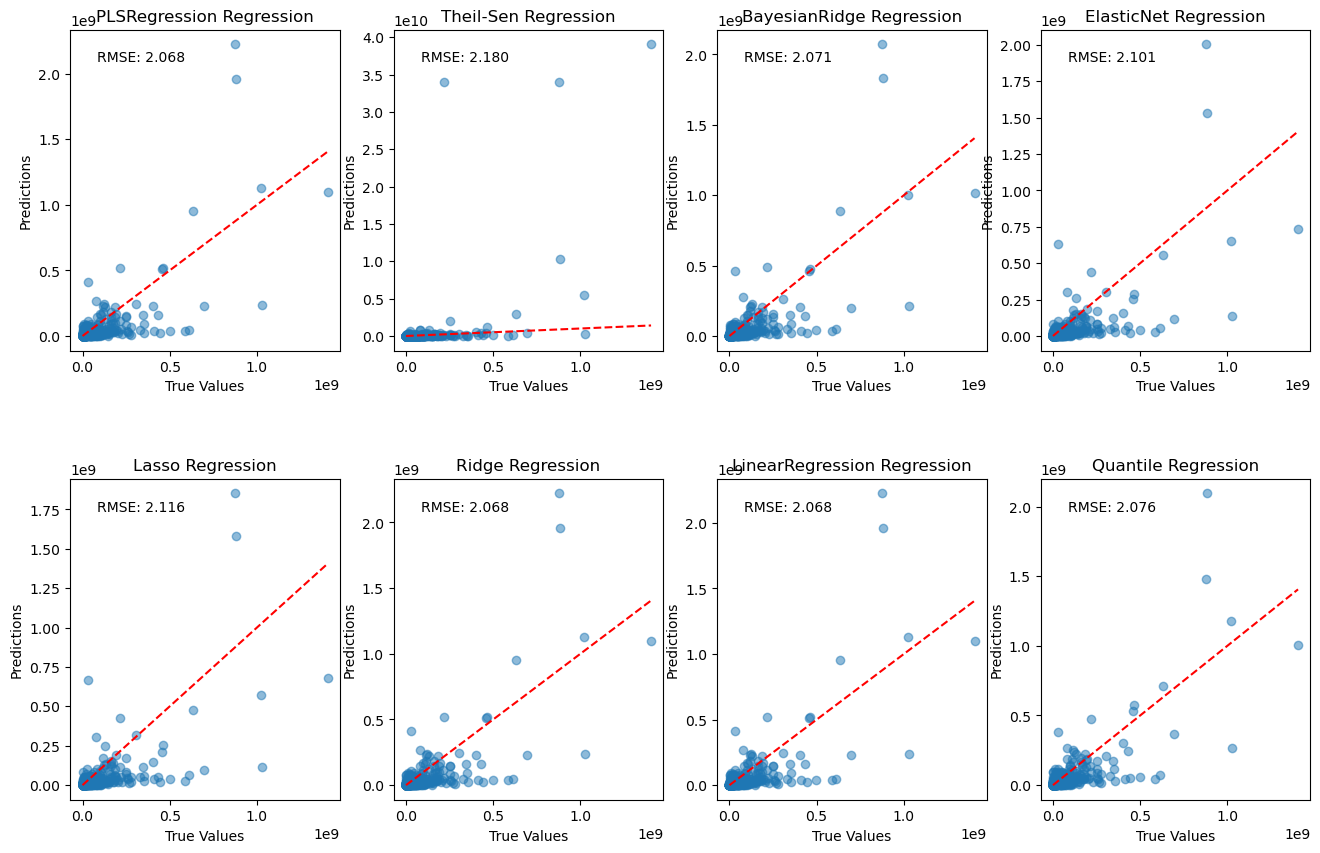

In [2]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, TheilSenRegressor, HuberRegressor, BayesianRidge
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 载入数据
train_data = pd.read_csv('../dataset/processed_dataset/train/processed_bop_train.csv', index_col=0, header=0)
test_data = pd.read_csv('../dataset/processed_dataset/test/processed_bop_test.csv', index_col=0, header=0)

train_data['log_budget'] = np.log1p(train_data['budget'])
test_data ['log_budget'] = np.log1p(test_data ['budget'])
train_data['log_revenue'] = np.log1p(train_data['revenue'])
test_data ['log_revenue'] = np.log1p(test_data ['revenue'])

# 划分标签和特征
X_train = train_data.drop(['budget','revenue','log_revenue'], axis=1)
y_train = train_data['log_revenue']
X_test = test_data.drop(['budget','revenue','log_revenue'], axis=1)
y_test = test_data['revenue']

# 训练并预测
models = [
    ('PLSRegression', PLSRegression(n_components=10)),
    ('Theil-Sen', TheilSenRegressor()),
    ('BayesianRidge', BayesianRidge()),
    ('ElasticNet', ElasticNet(alpha=0.1)),
    ('Lasso', Lasso(alpha=0.1)),
    ('Ridge', Ridge(alpha=1.0)),
    ('LinearRegression', LinearRegression()),
    ('Quantile', sm.QuantReg(y_train, X_train))
]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4)

for i, (name, model) in enumerate(models):
    if name == 'Quantile':
        res = np.expm1(model.fit(q=0.5).predict(X_test))
    else:
        model.fit(X_train, y_train)
        res = np.expm1(model.predict(X_test))
    
    axs[i//4][i%4].scatter(y_test, res, alpha=0.5)
    axs[i//4][i%4].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axs[i//4][i%4].set_xlabel('True Values')
    axs[i//4][i%4].set_ylabel('Predictions')
    axs[i//4][i%4].set_title(name + ' Regression')
    axs[i//4][i%4].text(0.1, 0.9, 'RMSE: {:.3f}'.format(np.sqrt(mean_squared_log_error(y_test, res))),
                         transform=axs[i//4][i%4].transAxes)
plt.savefig('linear_model_predictions.png')
plt.show()